In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import functions
from astropy.table import Table, vstack
import matplotlib.lines as mlines
import os
import emcee
from astropy.io import ascii
import corner
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f

## Filepaths and Loading in Data

In [2]:
current_dir = os.getcwd()
SNe_csv_dir = '/Users/adeutsch/Desktop/UVA/research-sn/Type_IIbSupernovae'

SN2001ig_csv = os.path.join(SNe_csv_dir, '01ig.csv')
SN2003bg_csv = os.path.join(SNe_csv_dir, '03bg.csv')
SN2016gkg_csv = os.path.join(SNe_csv_dir, '16gkg.csv')
SN2022crv_csv = os.path.join(SNe_csv_dir, '22crv.csv')

In [3]:
def load(sn_file, cols):
    t = Table.read(sn_file, format="csv")
    return t[cols]

cols = ["Date", "Time", "Tel", "Freq", "Flux (mJy)", "rms", "Lum", "Lum_Err", "nuLu", "nuLu_Err"]

SN2001ig  = load(SN2001ig_csv, cols)
SN2003bg  = load(SN2003bg_csv, cols)
SN2016gkg = load(SN2016gkg_csv, cols)
SN2022crv = load(SN2022crv_csv, cols)

In [4]:
# load in vlass data
sn2003bg_vlass_times = [5967.718681, 6931.02765, 7891.455741] #MJD
sn2003bg_vlass_flux = [3.8, 3.94, 2.81] #mJy
sn2003bg_vlass_rms = [0.16, 0.05, 0.10] #mJy

sn2016gkg_vlass_times = [1013.311343,1965.703808,2925.068623] #MJD
sn2016gkg_vlass_flux = [0.654, 0.96, 0.52] #mJy
sn2016gkg_vlass_rms = [0.0, 0.0, 0.13] #mJy

sn2017hyh_vlass_times = [1008.254468, 1928.714525, 2934.970926] #MJD
sn2017hyh_vlass_flux = [0.45, 0.84, 2.81] #mJy
sn2017hyh_vlass_rms = [0.0, 0.17, 0.13] #mJy

sn2022crv_vlass_times = [470.75681] #MJD
sn2022crv_vlass_flux = [3.98] #mJy
sn2022crv_vlass_rms = [0.12] #mJy

"""
MAKE SURE TO DENOTE AS UPPER LIMIT (WITH V) IF RMS == 0.0
"""

'\nMAKE SURE TO DENOTE AS UPPER LIMIT (WITH V) IF RMS == 0.0\n'

In [70]:
# load in time post explosion for requested VLA epoch for each SN
# 01ig, 03bg, 16gkg, 22crv, 17hyh
requested_vla_epoch = [(8969, 9153), (8527,8711),(3570.751563, 3754.751563),(1592.81181, 1776.81181),(3159.518009, 3343.518009)]

In [105]:
# load in sn2001ig atca data from soria et al 2025
sn2001ig_atca_times = np.array([4199.1,4201.1,7064.2,7064.2,8101.4,8101.4,8167.2,8172.2,8172.2])
sn2001ig_atca_freqs = np.array([2.1,2.1,5.5,9.0,5.5,9.0,2.1,5.5,9.0])
sn2001ig_atca_fluxes = np.array([6.90,7.15,2.64,1.20,3.22,1.93,8.00,3.30,1.95])
sn2001ig_atca_rms = np.array([0.28,0.29,0.11,0.10,0.09,0.20,0.20,0.09,0.08])

In [210]:
# load in sn 2017hyh askap data
phase_mjd_17hyh_askap = np.array([2057.758009, 1975.748009, 2031.488009, 2095.318009, 2152.248009, 2153.248009, 2270.878009, 2327.678009, 2389.508009, 2460.408009, 2466.388009, 2568.088009, 2623.888009, 2680.838009, 2752.628009])

flux_mjy_17hyh_askap = np.array([3.93, 3.82, 4.56, 7.30, 7.30, 6.96, 5.16, 9.40, 10.01, 10.18, 6.21, 5.27, 6.55, 7.43, 8.28])

freq_mhz_17hyh_askap = np.array([888, 888, 888, 888, 944, 944, 888, 888, 888, 1368, 1368, 888, 888, 888, 888])

flux_err_mjy_17hyh_askap = np.array([0.38, 0.40, 0.43, 0.61, 0.80, 0.51, 0.44, 0.67, 0.68, 1.83, 0.49, 0.44, 0.56, 0.53, 0.72])

# stack into an astropy table
sn2017hyh_askap_table = Table()
sn2017hyh_askap_table['MJD'] = phase_mjd_17hyh_askap
sn2017hyh_askap_table['Flux (mJy)'] = flux_mjy_17hyh_askap
sn2017hyh_askap_table['Freq'] = freq_mhz_17hyh_askap / 1000.0 # convert to GHz
sn2017hyh_askap_table['rms'] = flux_err_mjy_17hyh_askap

## Set color scheme for plotting

In [100]:
sne_marker_colors = {
    'SN2001ig': {
        'marker_color': 'skyblue',
        'marker_edge_color': 'blue'
    },
    'SN2003bg': {
        'marker_color': 'palegreen',
        'marker_edge_color': 'darkseagreen'
    },
    'SN2016gkg': {
        'marker_color': 'lightsalmon',
        'marker_edge_color': 'peru'
    },
    'SN2022crv': {
        'marker_color': 'mediumpurple',
        'marker_edge_color': 'rebeccapurple'
    },
    'SN2017hyh': {
        'marker_color': 'yellow',
        'marker_edge_color': 'olive'
    }
}

## Set up top x-axis for years pre-explosion

In [162]:
v_shock = 10000  # km/s
v_wind = 120     # km/s
ratio = v_shock / v_wind

def days_to_years_pre(days):
    return days * ratio / 365.25

def years_pre_to_days(years):
    return years * 365.25 / ratio

# determine years-pre explosion mass-loss rates measurements would be probed by requested epochs:
requested_vla_years = days_to_years_pre(np.array([epoch[0] for epoch in requested_vla_epoch]))

## Inspect the most common frequencies for each SN

In [71]:
# Count observations at each frequency for all supernovae
frequencies_count = {}
sn_names = ['SN2001ig', 'SN2003bg', 'SN2016gkg', 'SN2022crv', 'SN2017hyh']
count = 0
for sn in [SN2001ig, SN2003bg, SN2016gkg, SN2022crv]:
    unique_freqs, counts_freqs = np.unique(sn['Freq'], return_counts=True)
    print(f"Frequencies and counts for SN {sn_names[count]}:\n{np.array(unique_freqs)}\n{counts_freqs}\n")
    count += 1


Frequencies and counts for SN SN2001ig:
[ 1.4  2.4  4.8  8.6 15.  18.8 22.5]
[26 23 34 32  4  3  4]

Frequencies and counts for SN SN2003bg:
[ 0.33  0.62  1.28  1.4   4.86  8.46 15.   22.5  43.3 ]
[ 1  1  1 31 38 42 35 33 10]

Frequencies and counts for SN SN2016gkg:
[ 0.325  0.61   1.39   1.749  2.499  3.499  4.999  7.099  8.549  9.499
 10.999 13.499 16.499 19.299 24.999  0.   ]
[1 9 9 1 4 4 4 4 5 1 4 1 1 3 3 2]

Frequencies and counts for SN SN2022crv:
[0.44 0.69 1.37 5.5  9.  ]
[1 4 4 8 8]



In [72]:
SN2001ig_one = SN2001ig[SN2001ig['Freq'] == 1.4]
SN2003bg_one = SN2003bg[SN2003bg['Freq'] == 1.4]
SN2016gkg_one = SN2016gkg[SN2016gkg['Freq'] == 1.39]
SN2022crv_one = SN2022crv[SN2022crv['Freq'] == 1.37]

SN2001ig_five = SN2001ig[SN2001ig['Freq'] == 4.8]
SN2003bg_five = SN2003bg[SN2003bg['Freq'] == 4.86]
SN2016gkg_five = SN2016gkg[SN2016gkg['Freq'] == 4.999]
SN2022crv_five = SN2022crv[SN2022crv['Freq'] == 5.5]

SN2001ig_nine = SN2001ig[SN2001ig['Freq'] == 8.6]
SN2003bg_nine = SN2003bg[SN2003bg['Freq'] == 8.46]
SN2016gkg_nine = SN2016gkg[SN2016gkg['Freq'] == 8.549]
SN2022crv_nine = SN2022crv[SN2022crv['Freq'] == 9.0]

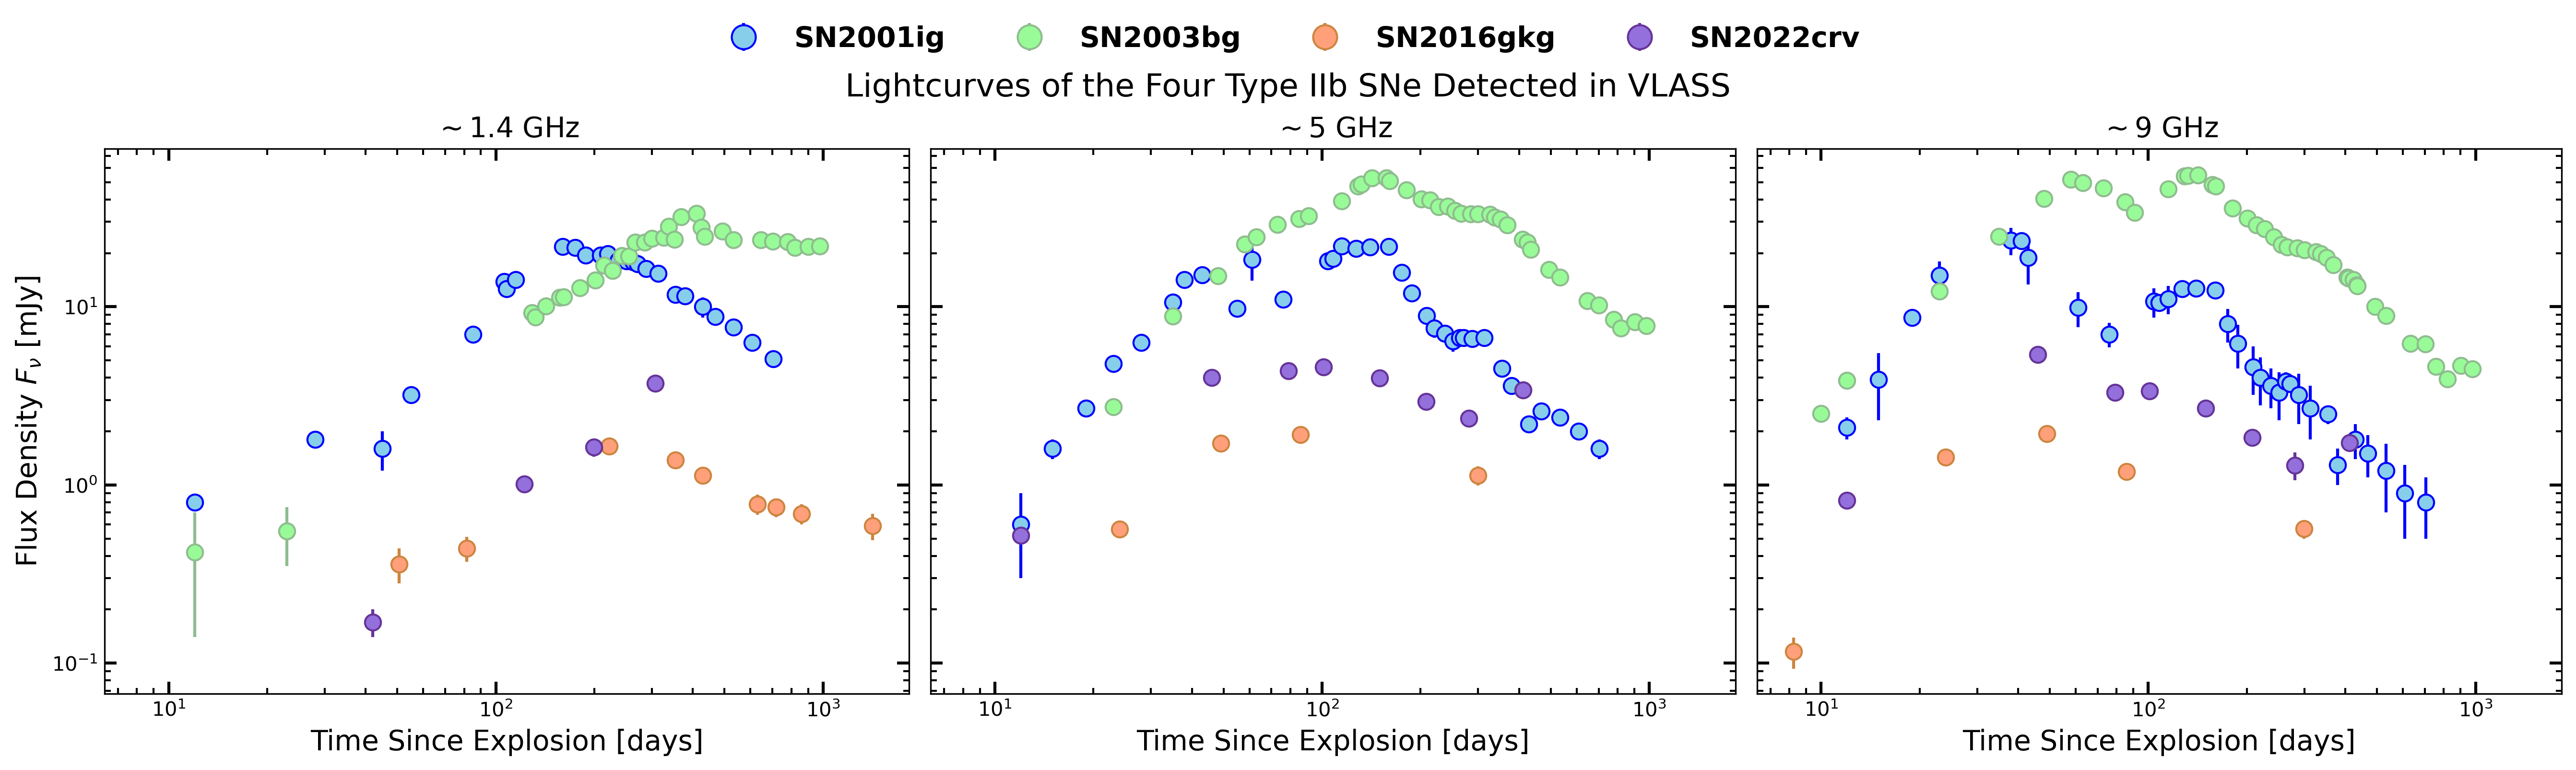

In [164]:
# Make figure with 3 subplots for 3 frequencies plotted at once
fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=300, sharex=True, sharey=True)

# --- Plot 1.4 GHz ---
ax[0].errorbar(SN2001ig_one['Time'], SN2001ig_one['Flux (mJy)'], SN2001ig_one['rms'], label='SN2001ig',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2001ig']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2001ig']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2001ig']['marker_edge_color'])
ax[0].errorbar(SN2003bg_one['Time'], SN2003bg_one['Flux (mJy)'], SN2003bg_one['rms'], label='SN2003bg',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2003bg']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2003bg']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2003bg']['marker_edge_color'])
ax[0].errorbar(SN2016gkg_one['Time'], SN2016gkg_one['Flux (mJy)'], SN2016gkg_one['rms'], label='SN2016gkg',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2016gkg']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'])
ax[0].errorbar(SN2022crv_one['Time'], SN2022crv_one['Flux (mJy)'], SN2022crv_one['rms'], label='SN2022crv',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2022crv']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2022crv']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2022crv']['marker_edge_color'])

ax[0].set_title(r'$\sim1.4$ GHz',fontsize=14)

# --- Plot 5 GHz ---
ax[1].errorbar(SN2001ig_five['Time'], SN2001ig_five['Flux (mJy)'], SN2001ig_five['rms'], label='SN2001ig',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2001ig']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2001ig']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2001ig']['marker_edge_color'])
ax[1].errorbar(SN2003bg_five['Time'], SN2003bg_five['Flux (mJy)'], SN2003bg_five['rms'], label='SN2003bg',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2003bg']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2003bg']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2003bg']['marker_edge_color'])
ax[1].errorbar(SN2016gkg_five['Time'], SN2016gkg_five['Flux (mJy)'], SN2016gkg_five['rms'], label='SN2016gkg',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2016gkg']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'])
ax[1].errorbar(SN2022crv_five['Time'], SN2022crv_five['Flux (mJy)'], SN2022crv_five['rms'], label='SN2022crv',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2022crv']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2022crv']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2022crv']['marker_edge_color'])

ax[1].set_title(r'$\sim5$ GHz',fontsize=14)

# --- Plot 9 GHz ---
ax[2].errorbar(SN2001ig_nine['Time'], SN2001ig_nine['Flux (mJy)'], SN2001ig_nine['rms'], label='SN2001ig',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2001ig']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2001ig']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2001ig']['marker_edge_color'])
ax[2].errorbar(SN2003bg_nine['Time'], SN2003bg_nine['Flux (mJy)'], SN2003bg_nine['rms'], label='SN2003bg',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2003bg']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2003bg']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2003bg']['marker_edge_color'])
ax[2].errorbar(SN2016gkg_nine['Time'], SN2016gkg_nine['Flux (mJy)'], SN2016gkg_nine['rms'], label='SN2016gkg',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2016gkg']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'])
ax[2].errorbar(SN2022crv_nine['Time'], SN2022crv_nine['Flux (mJy)'], SN2022crv_nine['rms'], label='SN2022crv',
               marker='o', markersize=8, linestyle='',
               markerfacecolor=sne_marker_colors['SN2022crv']['marker_color'],
               markeredgecolor=sne_marker_colors['SN2022crv']['marker_edge_color'],
               ecolor=sne_marker_colors['SN2022crv']['marker_edge_color'])

ax[2].set_title(r'$\sim9$ GHz',fontsize=14)


for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.tick_params(
        direction='in',
        which='major',
        width=1.5,
        length=6,
        top=True,
        right=True
    )
    a.tick_params(
        direction='in',
        which='minor',
        width=1.0,
        length=3,
        top=True,
        right=True
    )
    a.set_xlabel('Time Since Explosion [days]',fontsize=14)

ax[0].set_ylabel(r'Flux Density $F_{\nu}$ [mJy]',fontsize=14)

# Collect handles/labels from one axis (they're identical across panels)
handles, labels = ax[0].get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=4,                 # number of columns (one per SN)
    fontsize=14,            # larger text
    frameon=False,
    bbox_to_anchor=(0.5, 1.08),  # center above the figure
    markerscale=1.5,
    prop={'weight': 'bold', 'size': 14}
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Lightcurves of the Four Type IIb SNe Detected in VLASS',fontsize=16)
plt.savefig('TypeIIb_Lightcurves_FreqComp.pdf', bbox_inches='tight')

In [222]:
import numpy as np

def fit_powerlaw_loglog(t, f, ferr=None):
    """
    Fit f = A * t^m via log10: log f = m log t + b, A = 10^b.
    Weighted if ferr provided.
    Returns A, m.
    """
    t = np.asarray(t, float)
    f = np.asarray(f, float)

    good = (t > 0) & (f > 0) & np.isfinite(t) & np.isfinite(f)
    if ferr is not None:
        ferr = np.asarray(ferr, float)
        good &= (ferr > 0) & np.isfinite(ferr)

    t, f = t[good], f[good]
    if ferr is not None:
        ferr = ferr[good]

    x = np.log10(t)
    y = np.log10(f)

    if ferr is None:
        w = np.ones_like(y)
    else:
        # sigma(log10 f) ~ sigma_f / (f ln 10)
        sigma_y = ferr / (f * np.log(10))
        w = 1.0 / sigma_y**2

    # Weighted linear regression: y = m x + b
    A = np.vstack([x, np.ones_like(x)]).T
    W = np.diag(w)
    beta = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ y)
    m, b = beta[0], beta[1]
    return 10**b, m


def plot_wind_baseline(ax, t, f, ferr, sn_name, tmin=None, tmax=None, label_suffix='wind-like fit'):
    """
    Fit power law to early-time window and plot dashed baseline.
    """
    t = np.asarray(t, float)
    f = np.asarray(f, float)
    ferr = np.asarray(ferr, float)

    sel = np.isfinite(t) & np.isfinite(f) & (t > 0) & (f > 0)
    if tmin is not None:
        sel &= (t >= tmin)
    if tmax is not None:
        sel &= (t <= tmax)

    if sel.sum() < 3:
        return  # not enough points to fit robustly

    Apl, mpl = fit_powerlaw_loglog(t[sel], f[sel], ferr[sel])

    # draw baseline across the plot x-range (or just across your data range)
    t_plot = np.logspace(np.log10(t.min()), np.log10(t.max()*1.5), 200)
    f_plot = Apl * t_plot**mpl

    c = sne_marker_colors[sn_name]['marker_color']
    ax.plot(t_plot, f_plot, ls='--', lw=2, color=c,
            label=f'{sn_name} {label_suffix} ($m={mpl:.2f}$)')

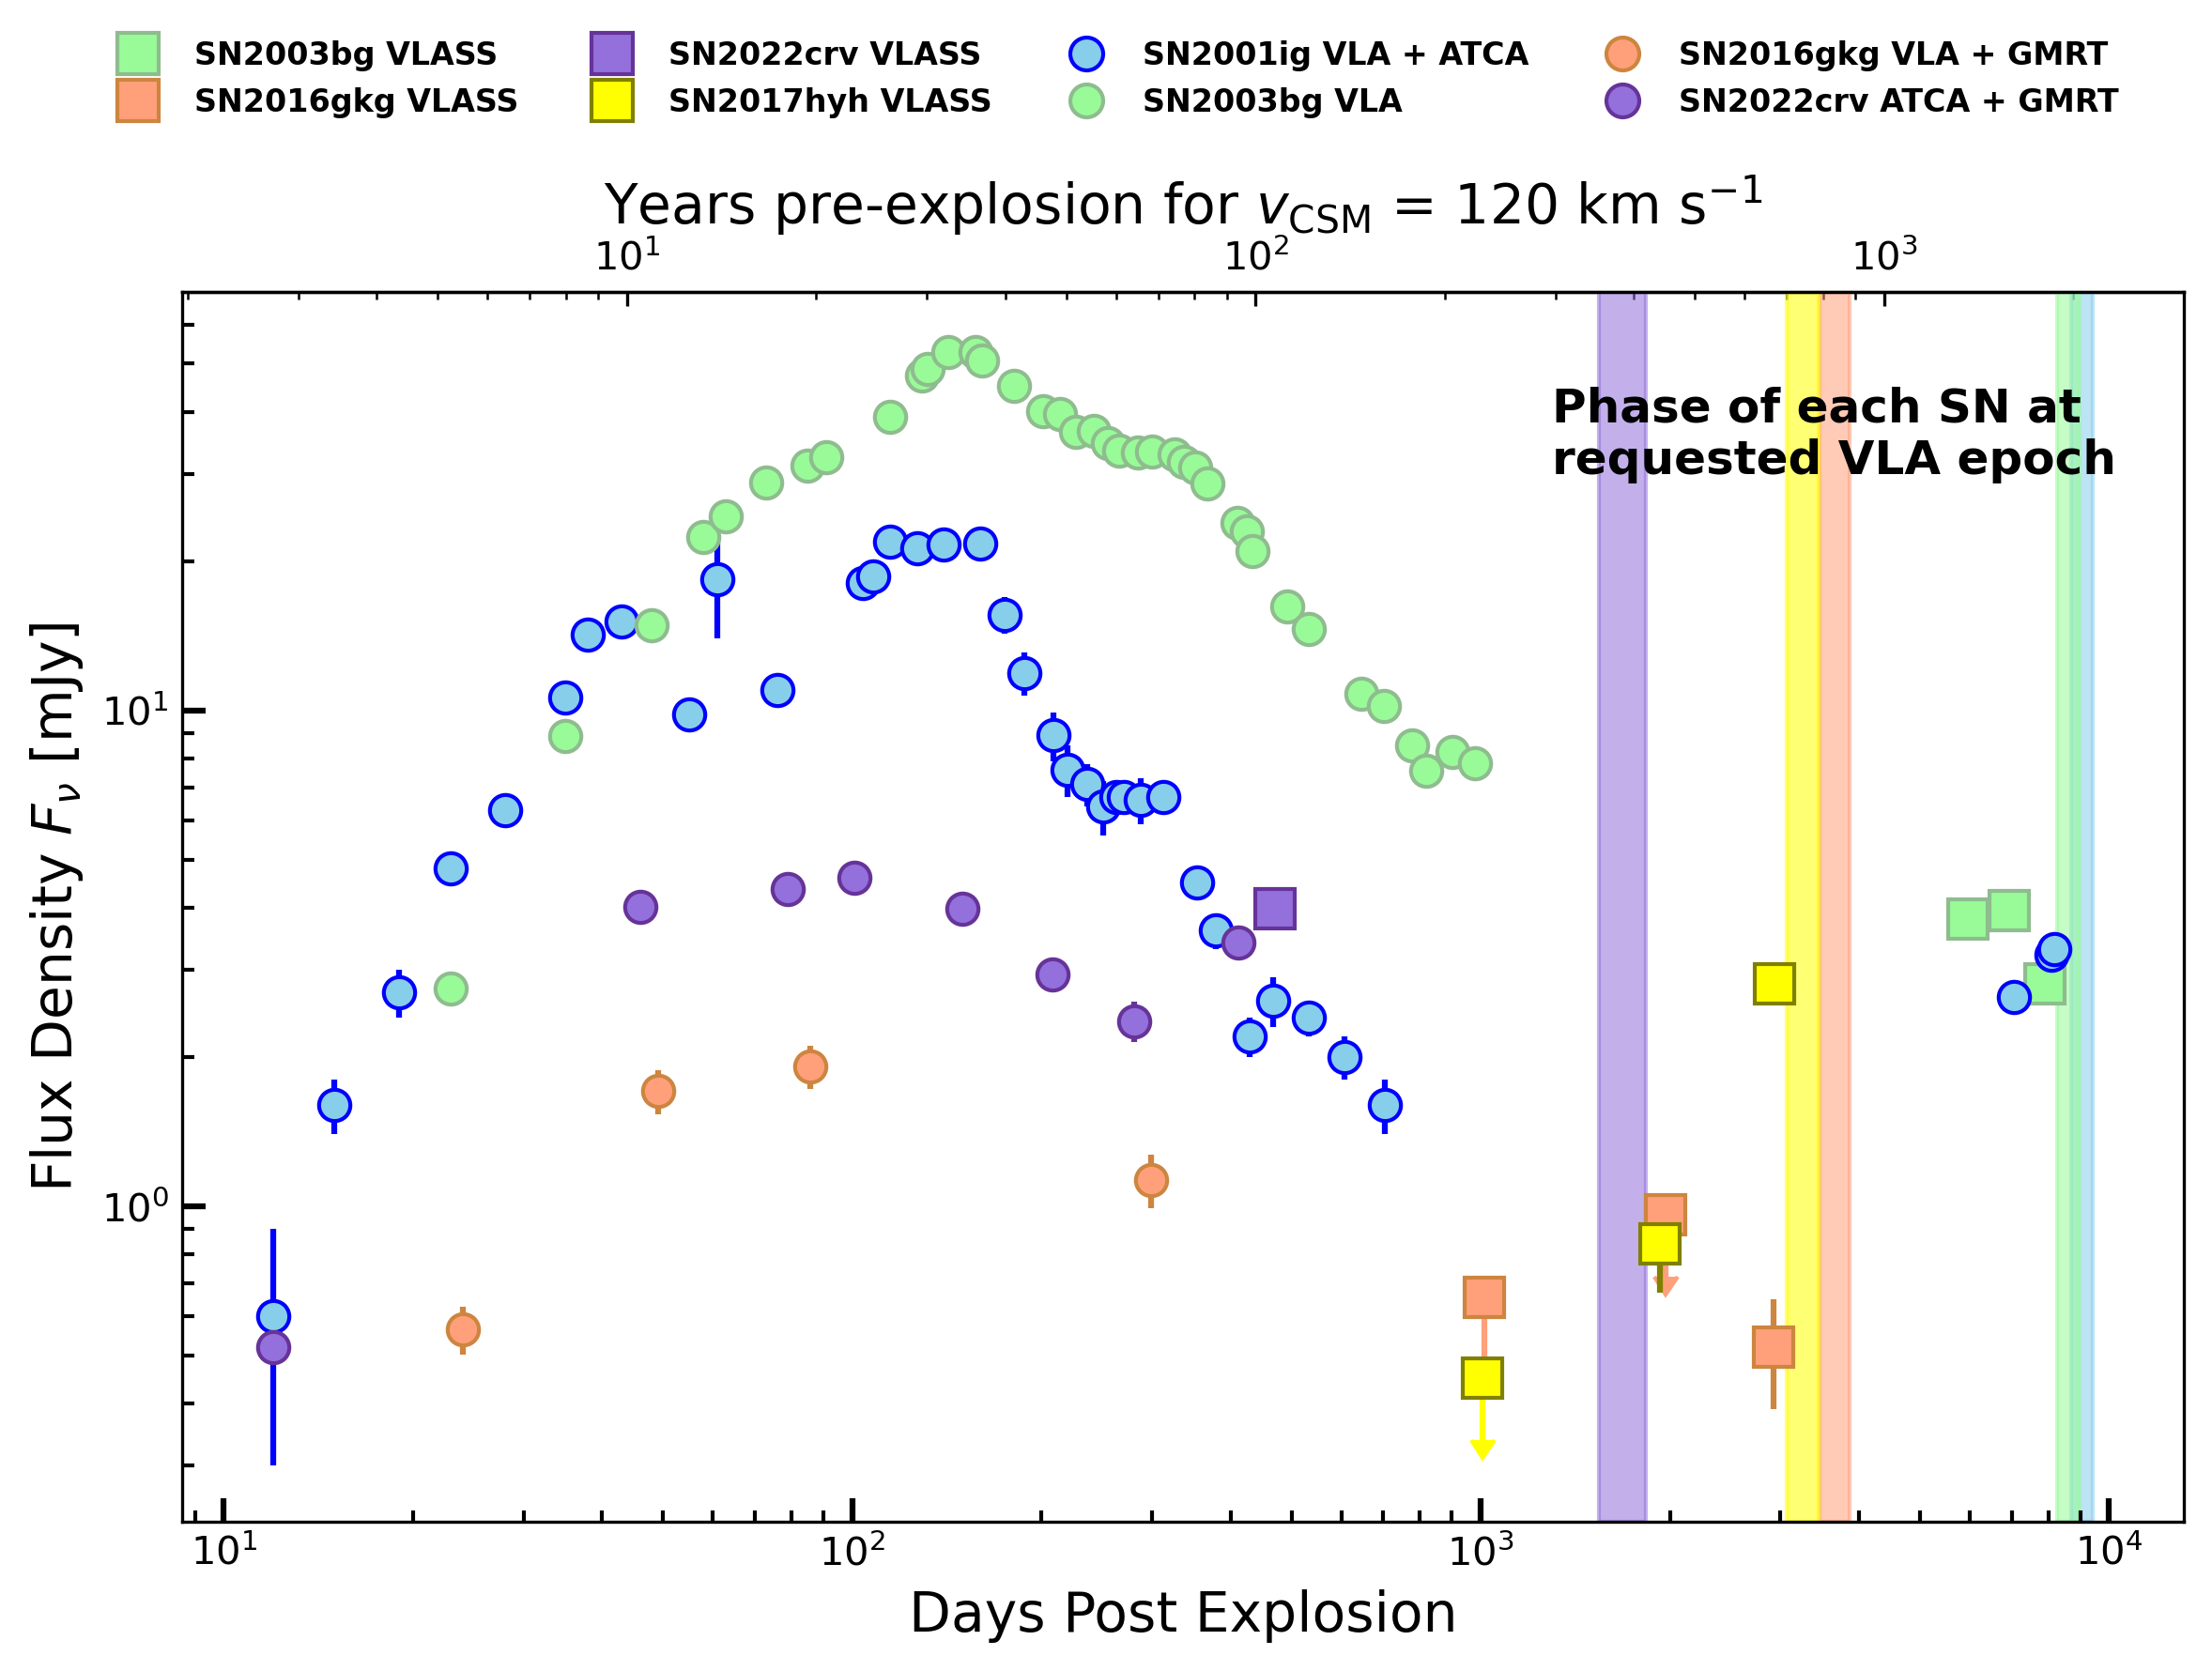

In [225]:
fig = plt.figure(dpi=300, figsize=(8,6))

UL_MARKER_SIZE = 10
UL_FALLBACK_FRAC = 0.25   # controls arrow length when rms == 0

def plot_vlass(times, fluxes, rms_vals, sn_name, label):
    c_face = sne_marker_colors[sn_name]['marker_color']
    c_edge = sne_marker_colors[sn_name]['marker_edge_color']

    for time, flux, rms in zip(times, fluxes, rms_vals):
        if rms == 0.0:
            yerr_ul = max(flux * UL_FALLBACK_FRAC, 1e-6)
            plt.errorbar(
                time, flux,
                yerr=yerr_ul,
                uplims=True,
                fmt='s',
                markersize=UL_MARKER_SIZE,
                linestyle='',
                markerfacecolor=c_face,
                markeredgecolor=c_edge, 
                ecolor=c_face
            )
        else:
            plt.errorbar(
                time, flux,
                yerr=rms,
                marker='s',
                markersize=10,
                linestyle='',
                markerfacecolor=c_face,
                markeredgecolor=c_edge,
                ecolor=c_edge,
                label=label
            )

# --- Call helper for each SN ---
plot_vlass(sn2003bg_vlass_times, sn2003bg_vlass_flux, sn2003bg_vlass_rms,
           'SN2003bg', 'SN2003bg VLASS')

plot_vlass(sn2016gkg_vlass_times, sn2016gkg_vlass_flux, sn2016gkg_vlass_rms,
           'SN2016gkg', 'SN2016gkg VLASS')

plot_vlass(sn2022crv_vlass_times, sn2022crv_vlass_flux, sn2022crv_vlass_rms,
           'SN2022crv', 'SN2022crv VLASS')

plot_vlass(sn2017hyh_vlass_times, sn2017hyh_vlass_flux, sn2017hyh_vlass_rms,
           'SN2017hyh', 'SN2017hyh VLASS')

# --- Plot 5 GHz VLA data ---
plt.errorbar(SN2001ig_five['Time'], SN2001ig_five['Flux (mJy)'], SN2001ig_five['rms'], label='SN2001ig VLA + ATCA',
             marker='o', markersize=8, linestyle='',
             markerfacecolor=sne_marker_colors['SN2001ig']['marker_color'],
             markeredgecolor=sne_marker_colors['SN2001ig']['marker_edge_color'],
             ecolor=sne_marker_colors['SN2001ig']['marker_edge_color'])

plt.errorbar(SN2003bg_five['Time'], SN2003bg_five['Flux (mJy)'], SN2003bg_five['rms'], label='SN2003bg VLA',
             marker='o', markersize=8, linestyle='',
             markerfacecolor=sne_marker_colors['SN2003bg']['marker_color'],
             markeredgecolor=sne_marker_colors['SN2003bg']['marker_edge_color'],
             ecolor=sne_marker_colors['SN2003bg']['marker_edge_color'])

plt.errorbar(SN2016gkg_five['Time'], SN2016gkg_five['Flux (mJy)'], SN2016gkg_five['rms'], label='SN2016gkg VLA + GMRT',
             marker='o', markersize=8, linestyle='',
             markerfacecolor=sne_marker_colors['SN2016gkg']['marker_color'],
             markeredgecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'],
             ecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'])

plt.errorbar(SN2022crv_five['Time'], SN2022crv_five['Flux (mJy)'], SN2022crv_five['rms'], label='SN2022crv ATCA + GMRT',
             marker='o', markersize=8, linestyle='',
             markerfacecolor=sne_marker_colors['SN2022crv']['marker_color'],
             markeredgecolor=sne_marker_colors['SN2022crv']['marker_edge_color'],
             ecolor=sne_marker_colors['SN2022crv']['marker_edge_color'])

# Plot ATCA data for SN2001ig from both 2.1 and 5.5 GHz, in correct color
atca_mask = (np.array(sn2001ig_atca_freqs) == 5.5)
plt.errorbar(sn2001ig_atca_times[atca_mask], sn2001ig_atca_fluxes[atca_mask], sn2001ig_atca_rms[atca_mask],
             marker='o', markersize=8, linestyle='',
             markerfacecolor=sne_marker_colors['SN2001ig']['marker_color'],
             markeredgecolor=sne_marker_colors['SN2001ig']['marker_edge_color'],
             ecolor=sne_marker_colors['SN2001ig']['marker_edge_color'])

# # Plot ASKAP data for SN2017hyh, in correct color, and only Freq = 1.36 GHz
# sn2017hyh_askap_table_plot = sn2017hyh_askap_table[sn2017hyh_askap_table['Freq'] == 1.368]
# plt.errorbar(sn2017hyh_askap_table_plot['MJD'], sn2017hyh_askap_table_plot['Flux (mJy)'], sn2017hyh_askap_table_plot['rms'],
#              marker='o', markersize=8, linestyle='',
#              markerfacecolor=sne_marker_colors['SN2017hyh']['marker_color'],
#              markeredgecolor=sne_marker_colors['SN2017hyh']['marker_edge_color'],
#              ecolor=sne_marker_colors['SN2017hyh']['marker_edge_color'],
#              label='SN2017hyh ASKAP')

# Plot ranges of vla requested epoch for each sn, in correct color
for i, (start, end) in enumerate(requested_vla_epoch):
    sn_name = sn_names[i]
    plt.axvspan(
        start*0.97,
        end*1.03,
        color=sne_marker_colors[sn_name]['marker_color'],
        alpha=0.55,
    )

# Scales
plt.xscale('log')
plt.yscale('log')

# Tick styling
plt.tick_params(direction='in', which='major', width=1.5, length=6)
plt.tick_params(direction='in', which='minor', width=1.0, length=3)

# Labels
plt.xlabel('Days Post Explosion', fontsize=14)
plt.ylabel(r'Flux Density $F_{\nu}$ [mJy]', fontsize=14)

ax = plt.gca()

# # Choose "early-time" windows 
# plot_wind_baseline(ax,
#     SN2001ig_five['Time'], SN2001ig_five['Flux (mJy)'], SN2001ig_five['rms'],
#     'SN2001ig', tmin=200, tmax=1000)

# plot_wind_baseline(ax,
#     SN2003bg_five['Time'], SN2003bg_five['Flux (mJy)'], SN2003bg_five['rms'],
#     'SN2003bg', tmin=200, tmax=1000)

# plot_wind_baseline(ax,
#     SN2016gkg_five['Time'], SN2016gkg_five['Flux (mJy)'], SN2016gkg_five['rms'],
#     'SN2016gkg', tmin=80, tmax=300)

# plot_wind_baseline(ax,
#     SN2022crv_five['Time'], SN2022crv_five['Flux (mJy)'], SN2022crv_five['rms'],
#     'SN2022crv', tmin=80, tmax=300)

secax = ax.secondary_xaxis(
    'top',
    functions=(days_to_years_pre, years_pre_to_days)
)
secax.set_xlabel(r'Years pre-explosion for $v_{\rm CSM}$ = 120 km s$^{-1}$', fontsize=14)
secax.tick_params(
    axis='x',
    which='both',
    direction='in',
    top=True,
    bottom=False,   # ← critical line
    labeltop=True,
    labelbottom=False
)

# --- Figure-level legend ---
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# keep first occurrence of each label
unique = {}
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h

fig.legend(
    unique.values(),
    unique.keys(),
    loc='upper center',
    ncol=4,
    frameon=False,
    markerscale=1.05,
    prop={'weight': 'bold', 'size': 8},
    bbox_to_anchor=(0.5, 0.99)
)

plt.text(1300, 30, 'Phase of each SN at \nrequested VLA epoch',fontsize=12, weight='bold')

fig.tight_layout(rect=[0, 0, 1, 0.92])
#plt.title('Lightcurves of the Five Requested Type IIb SNe', fontsize=16)
plt.savefig('VLASS_TypeIIb_Lightcurves_5GHz.pdf', dpi=300)

## Play around with the best SN to plot the SED's of to get mass-loss rate measurements

In [183]:
# load in mass loss rate and epochs of mass-loss rate measurements for SN 2016gkg from Nayana et al 2022
mdot_16gkg = np.array([2.2, 3.6, 3.8, 12.6, 3.7, 5.0])*10**-6
epoch_mdot_16gkg = np.array([8, 15, 25, 48, 87, 115]) # in years pre-explosion
vla_16gkg_epoch_range = (3570.751563, 3848.751563)

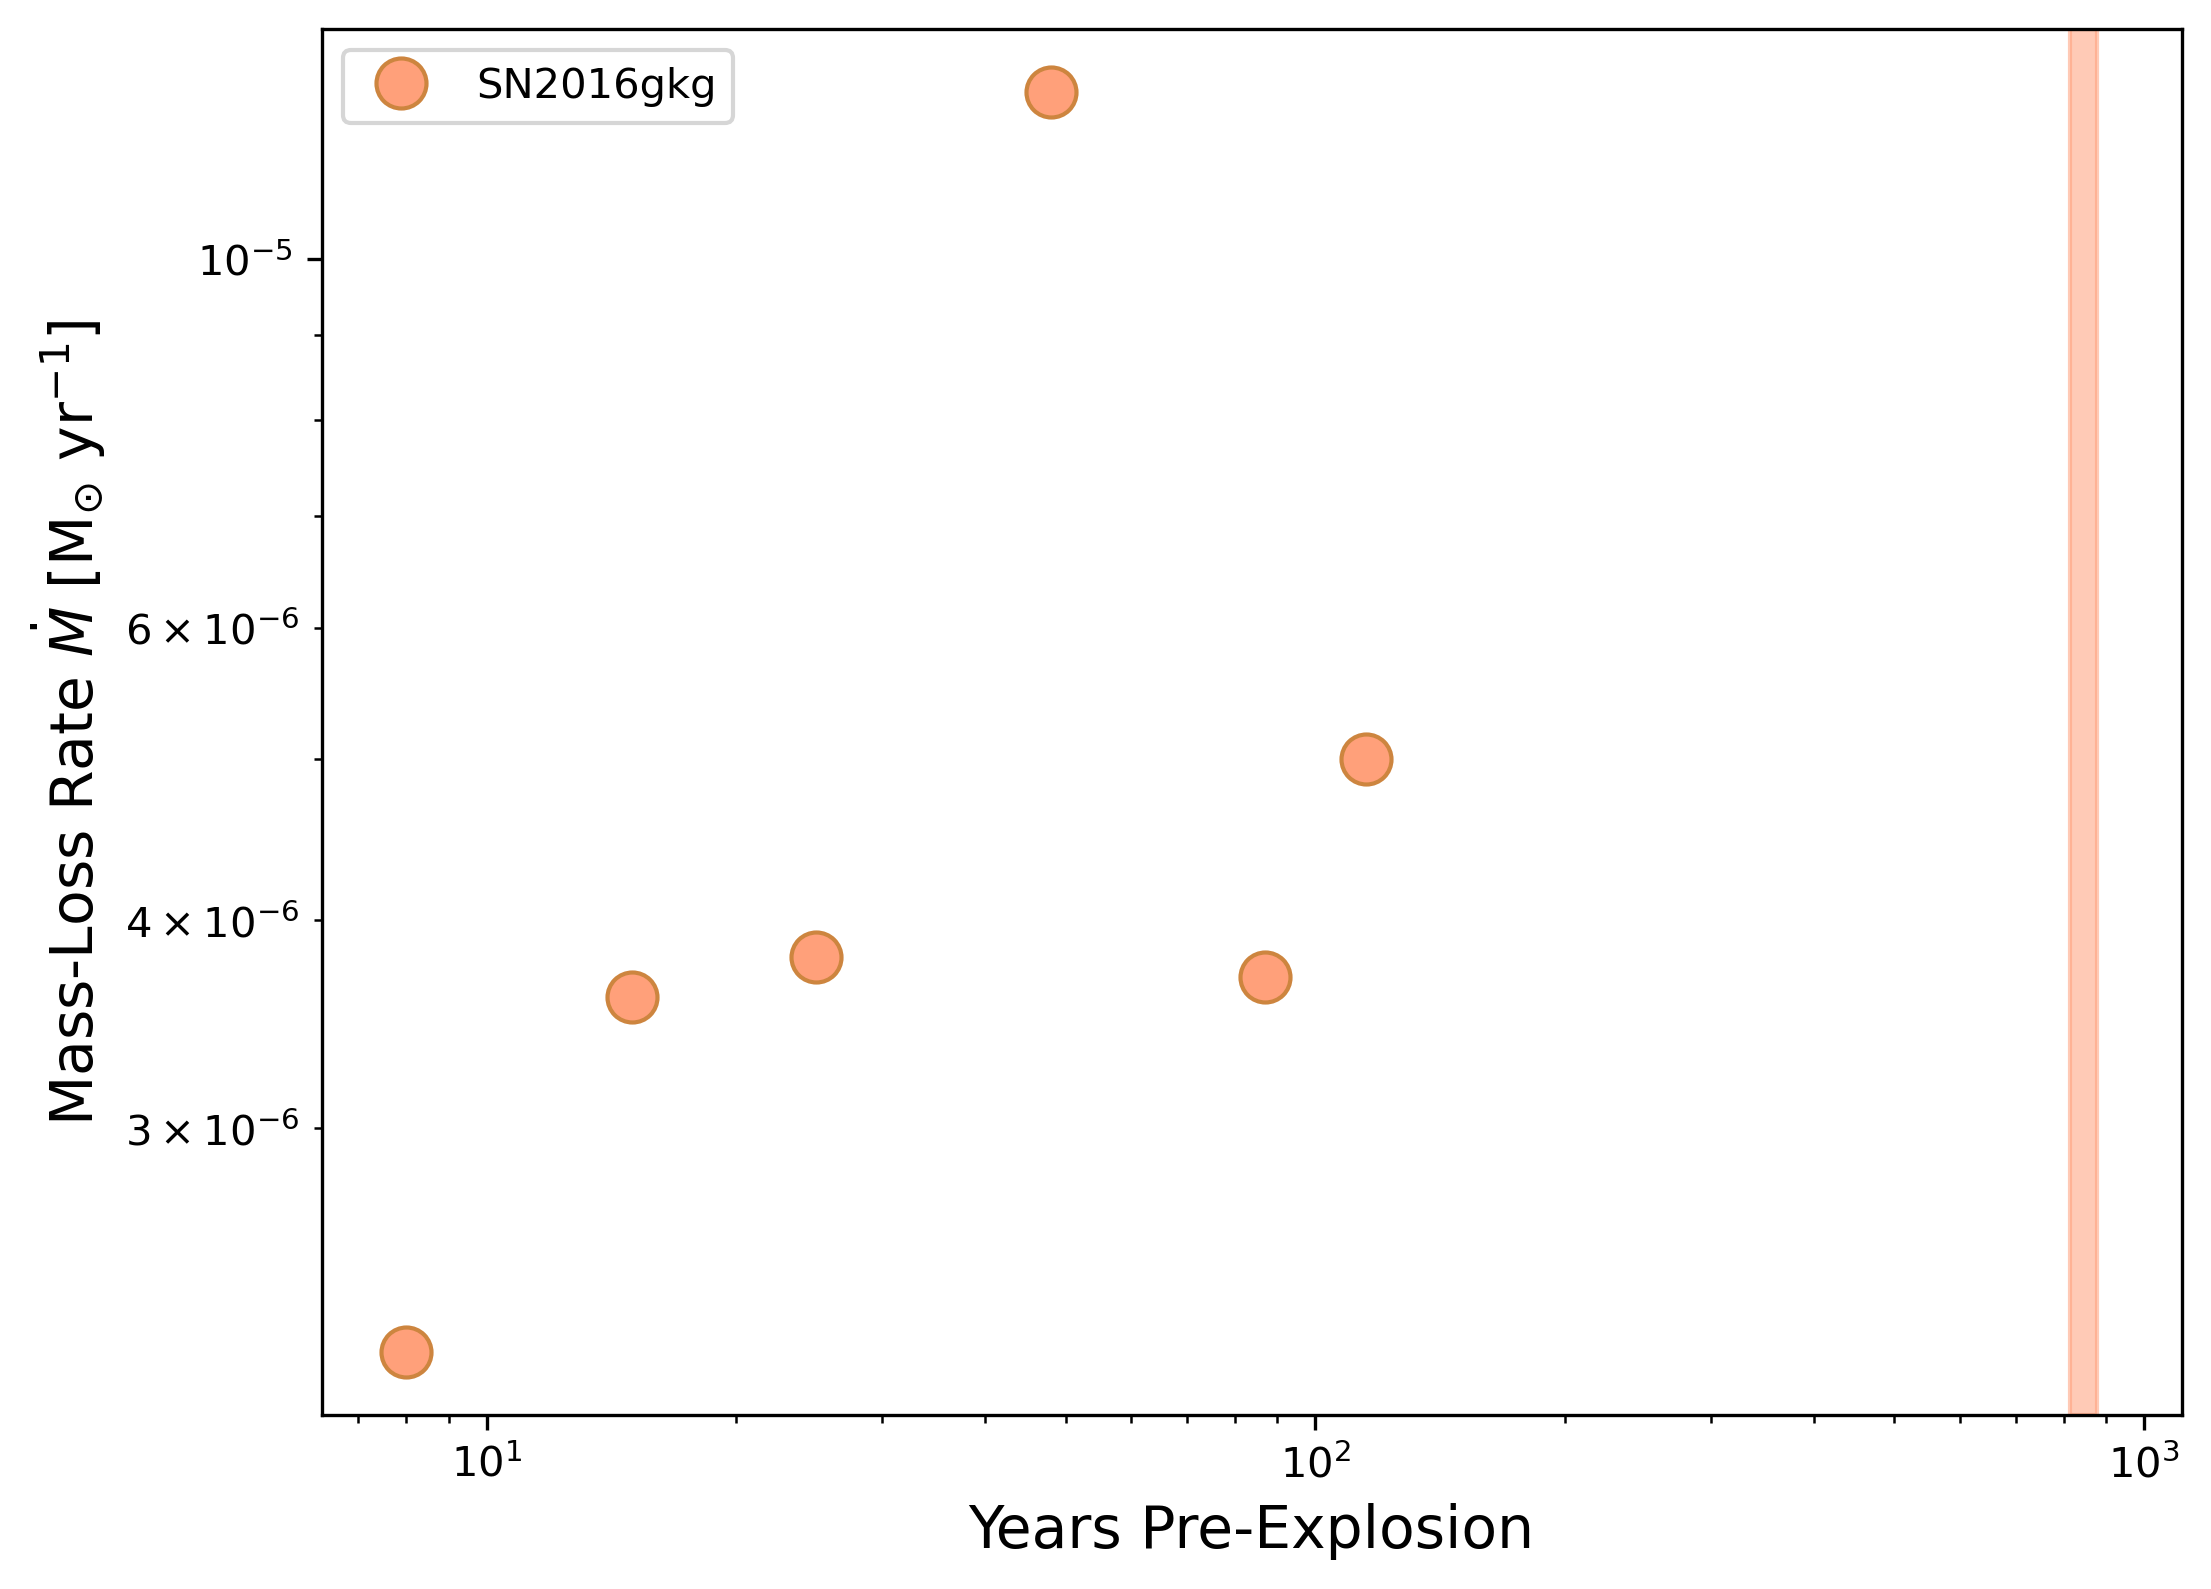

In [185]:
# plot mass-loss rate measurements vs years-pre explosion for SN 2016gkg in the same color and marker style as above
plt.figure(dpi=300, figsize=(8,6))
plt.errorbar(epoch_mdot_16gkg, mdot_16gkg, marker='o', markersize=12, linestyle='',
                markerfacecolor=sne_marker_colors['SN2016gkg']['marker_color'],
                markeredgecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'],
                ecolor=sne_marker_colors['SN2016gkg']['marker_edge_color'],
                label='SN2016gkg')
# plot vla epoch range as vertical shaded region
plt.axvspan(
    days_to_years_pre(vla_16gkg_epoch_range[0]),
    days_to_years_pre(vla_16gkg_epoch_range[1]),
    color=sne_marker_colors['SN2016gkg']['marker_color'],
    alpha=0.55,
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Years Pre-Explosion', fontsize=14)
plt.ylabel(r'Mass-Loss Rate $\dot{M}$ [M$_{\odot}$ yr$^{-1}$]', fontsize=14)
plt.legend()

## This isn't super compelling so we're gonna try something else: R^2F_nu vs R for just SN 2003bg, to show new parameter space being probed

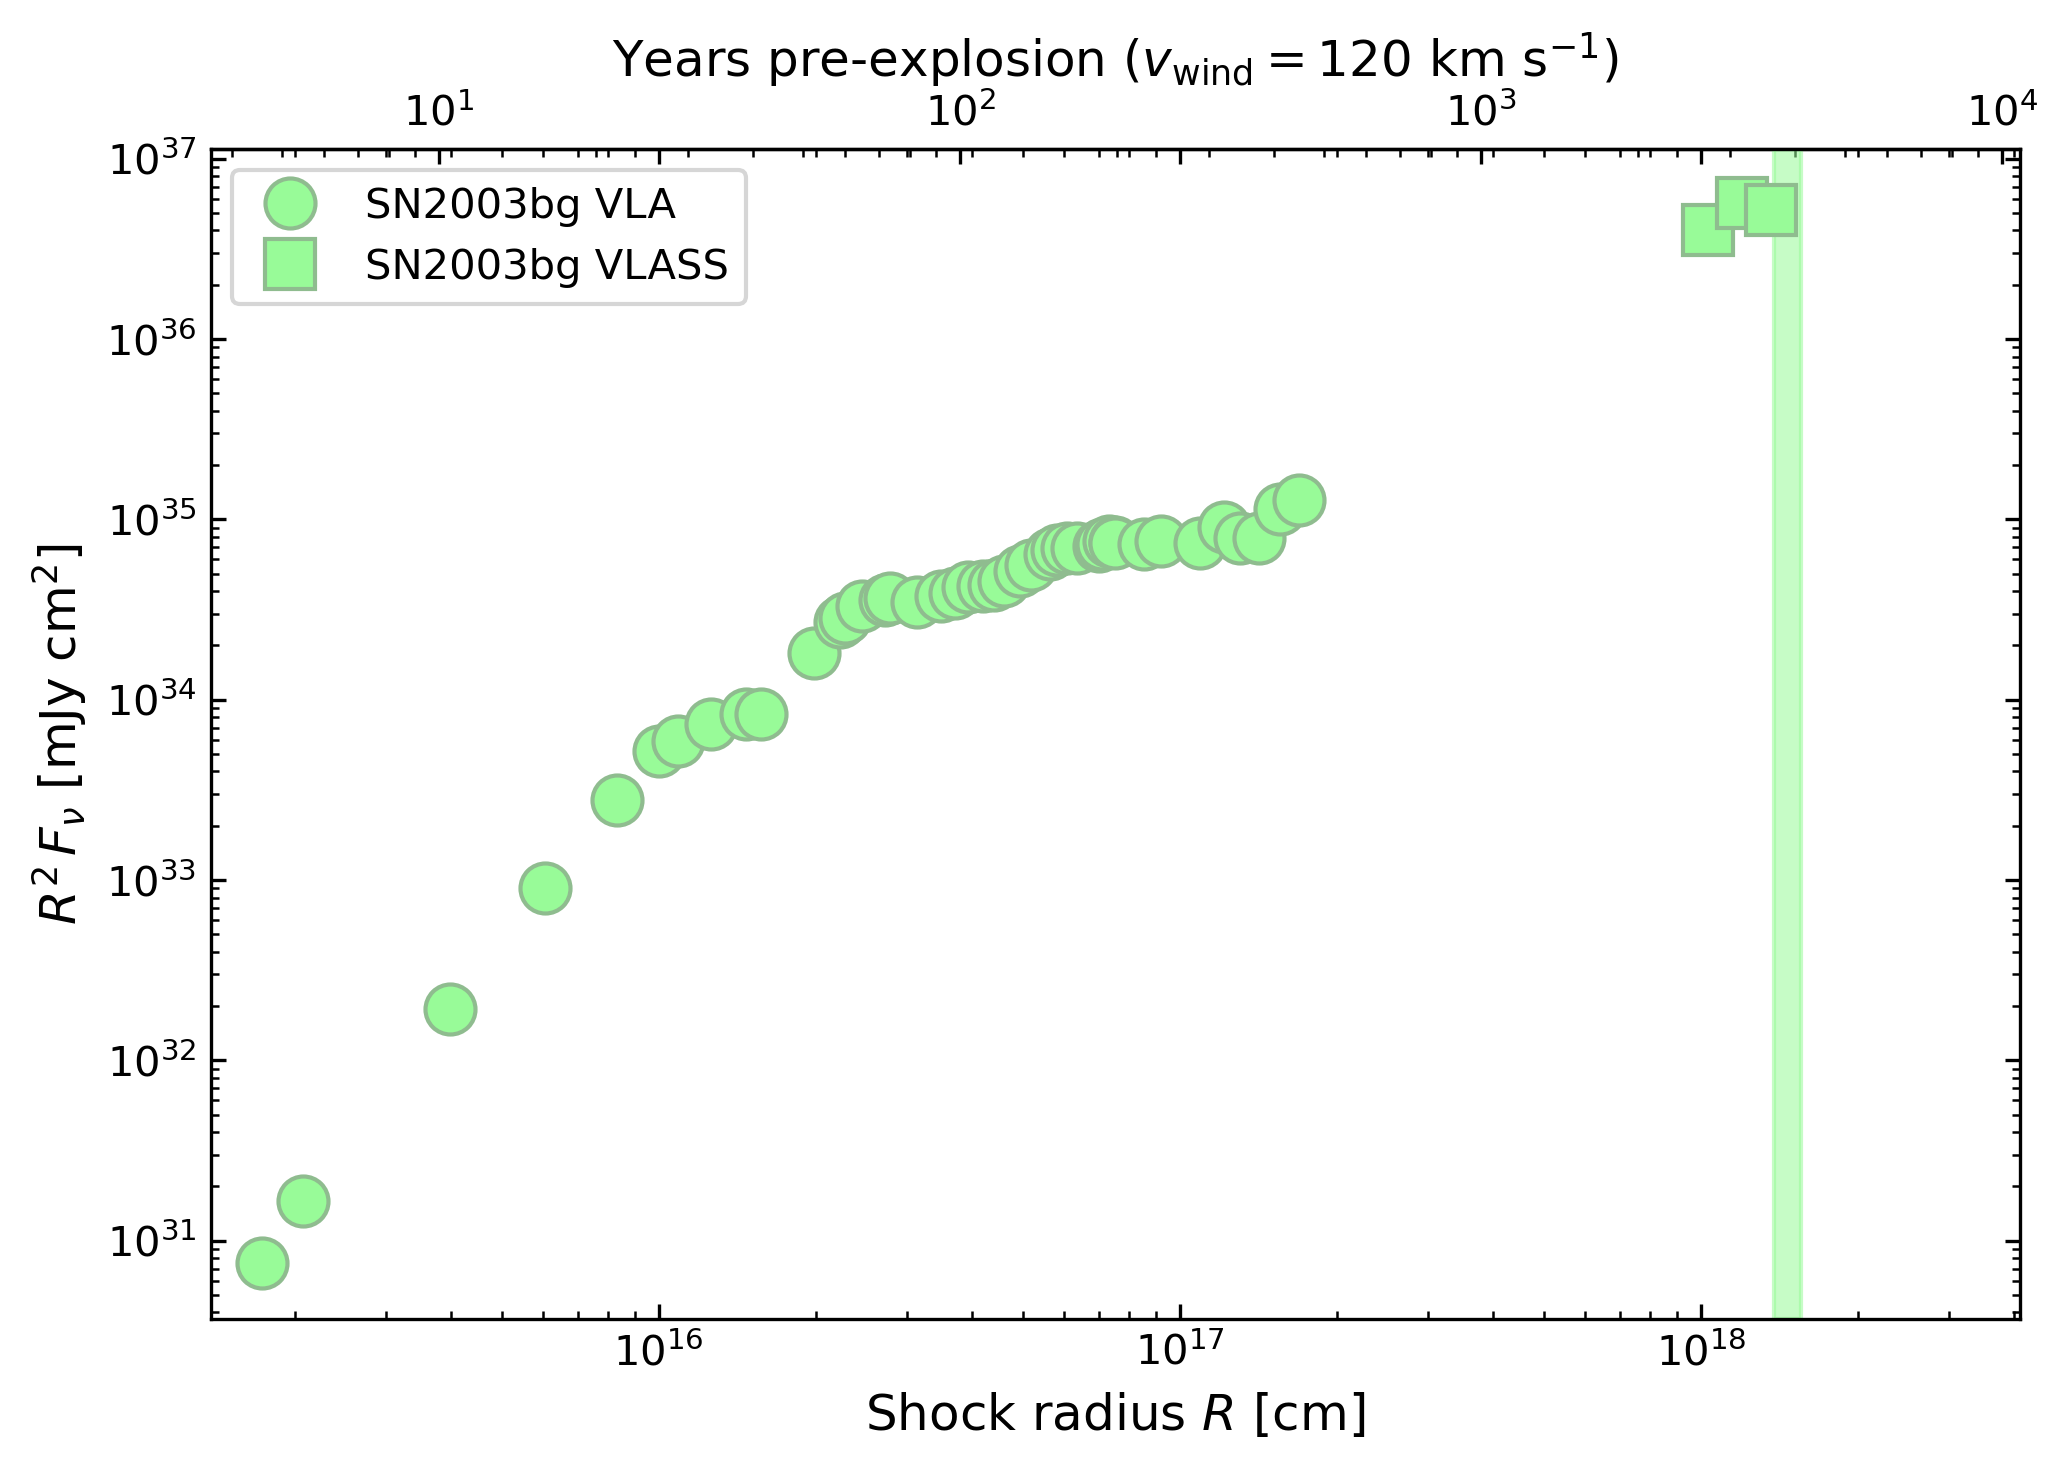

In [204]:
# Inputs
t_days = np.array(SN2003bg_nine['Time'], dtype=float)       
F_mJy  = np.array(SN2003bg_nine['Flux (mJy)'], dtype=float)      
Ferr_mJy = np.array(SN2003bg_nine['rms'], dtype=float)  

vlass_t_days = np.array(sn2003bg_vlass_times, dtype=float)
vlass_F_mJy  = np.array(sn2003bg_vlass_flux, dtype=float)
vlass_Ferr_mJy = np.array(sn2003bg_vlass_rms, dtype=float)

# Assumptions
v_sh_kms = 2.0e4
v_w_kms  = 120.0
sec_per_day = 86400.0
sec_per_year = 365.25 * 86400.0

# -------------------------------------------------
# Convert time → radius (cm)
# -------------------------------------------------
R_cm = (v_sh_kms * 1e5) * (t_days * sec_per_day) 
R_cm_vlass = (v_sh_kms * 1e5) * (vlass_t_days * sec_per_day)

# -------------------------------------------------
# Compute R^2 * F_nu
# -------------------------------------------------
R2F = (R_cm**2) * F_mJy
R2Ferr = (R_cm**2) * Ferr_mJy

R2F_vlass = (R_cm_vlass**2) * vlass_F_mJy
R2Ferr_vlass = (R_cm_vlass**2) * vlass_Ferr_mJy

# -------------------------------------------------
# Plot
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)

ax.errorbar(R_cm, R2F, yerr=R2Ferr, label='SN2003bg VLA',
             marker='o', markersize=12, linestyle='',
             markerfacecolor=sne_marker_colors['SN2003bg']['marker_color'],
             markeredgecolor=sne_marker_colors['SN2003bg']['marker_edge_color'],
             ecolor=sne_marker_colors['SN2003bg']['marker_edge_color'])

ax.errorbar(R_cm_vlass, R2F_vlass, yerr=R2Ferr_vlass, label='SN2003bg VLASS',
            marker='s', markersize=12, linestyle='',
            markerfacecolor=sne_marker_colors['SN2003bg']['marker_color'],
            markeredgecolor=sne_marker_colors['SN2003bg']['marker_edge_color'],
            ecolor=sne_marker_colors['SN2003bg']['marker_edge_color'])

# -------------------------------------------------
# Plot VLA epoch range
# -------------------------------------------------
vla_epoch_range = (8000, 9000)

ax.axvspan(
    (v_sh_kms * 1e5) * (vla_epoch_range[0] * sec_per_day),
    (v_sh_kms * 1e5) * (vla_epoch_range[1] * sec_per_day),
    color=sne_marker_colors['SN2003bg']['marker_color'],
    alpha=0.55,
)

# -------------------------------------------------
# Axis formatting
# -------------------------------------------------
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(direction='in', which='both', top=True, right=True)

plt.xlim(R_cm.min()*0.8, R_cm_vlass.max()*3)

ax.set_xlabel(r'Shock radius $R$ [cm]', fontsize=12)
ax.set_ylabel(r'$R^2\,F_{\nu}$ [mJy cm$^2$]', fontsize=12)

# -------------------------------------------------
# ⭐ Secondary top axis: years pre-explosion
# -------------------------------------------------
def R_to_years_pre(R):
    return R / (v_w_kms * 1e5) / sec_per_year

def years_pre_to_R(years):
    return years * sec_per_year * (v_w_kms * 1e5)

secax = ax.secondary_xaxis('top', functions=(R_to_years_pre, years_pre_to_R))
secax.set_xlabel(r'Years pre-explosion ($v_{\rm wind}=120$ km s$^{-1}$)', fontsize=12)
secax.tick_params(axis='x', which='both', direction='in', top=True, bottom=False)

plt.legend()
plt.tight_layout()
plt.show()